In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import torch
import torch.nn as nn
import pandas as pd

from utils import draw_circuit
from data import harmonic_oscillator_solution

In [59]:
sim = 'lightning.qubit' # default.qubit lightning.qubit lightning.gpu
torch_device = "cpu"
shots = 100 # 1000

In [60]:
### Full QC wrapper with a static data structure and variant input and weights only

def quantum_circuit(wires, input_wires, output_wires, rot='Ry'):
    def _quantum_circuit(inputs, weights): 
        # Prepare state H 
        [qml.Hadamard(i) for i in wires]

        # Encode classical -> quantum
        qml.AngleEmbedding(inputs, rotation='Y', wires=wires)

        # Process
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=wires)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=wires)
        
        # Measurement quantum -> classical
        return [qml.expval(qml.PauliZ(wires=w)) for w in output_wires]
    
    return _quantum_circuit

def quantum_circuit_shape(wires, n_layers=1, rot='Ry'):
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=wires)
    return shape

In [61]:
### Testing QC

n_qubits = 6
n_layers= 3


n_qubits_input = 1
n_qubits_output = 1

rotation = 'Rxyz'

### Define wires
wires = list(range(n_qubits))
input_wires = list(range(1))
output_wires = list(range(1))

In [62]:
# Data and weight shape
# Prepare test data
data_in = torch.linspace(1, 2, n_qubits_input, requires_grad=False)
print(f'Data shape ({data_in.shape}): \n{data_in}\n')

# Weights
weights_shape = quantum_circuit_shape(n_qubits, n_layers=n_layers, rot=rotation)
test_weights = np.prod(weights_shape)
print(f'QC weight shape: {weights_shape}, total: {test_weights}')

weights_in = torch.rand(weights_shape, requires_grad=True)
print(f'Weights ({weights_in.shape}): \n{weights_in}\n')

Data shape (torch.Size([1])): 
tensor([1.])

QC weight shape: (3, 6, 3), total: 54
Weights (torch.Size([3, 6, 3])): 
tensor([[[0.9942, 0.7336, 0.7432],
         [0.1596, 0.2403, 0.4805],
         [0.4924, 0.0680, 0.6648],
         [0.9645, 0.1383, 0.0745],
         [0.8792, 0.4552, 0.7754],
         [0.9061, 0.5707, 0.4396]],

        [[0.4246, 0.3505, 0.6171],
         [0.3970, 0.7564, 0.2623],
         [0.7485, 0.9129, 0.3164],
         [0.9690, 0.5881, 0.2345],
         [0.5532, 0.5684, 0.1659],
         [0.5282, 0.5411, 0.7373]],

        [[0.2346, 0.3278, 0.1095],
         [0.4279, 0.7531, 0.6875],
         [0.1509, 0.7471, 0.1203],
         [0.2356, 0.7399, 0.6075],
         [0.3544, 0.9800, 0.6950],
         [0.4824, 0.8086, 0.4796]]], requires_grad=True)



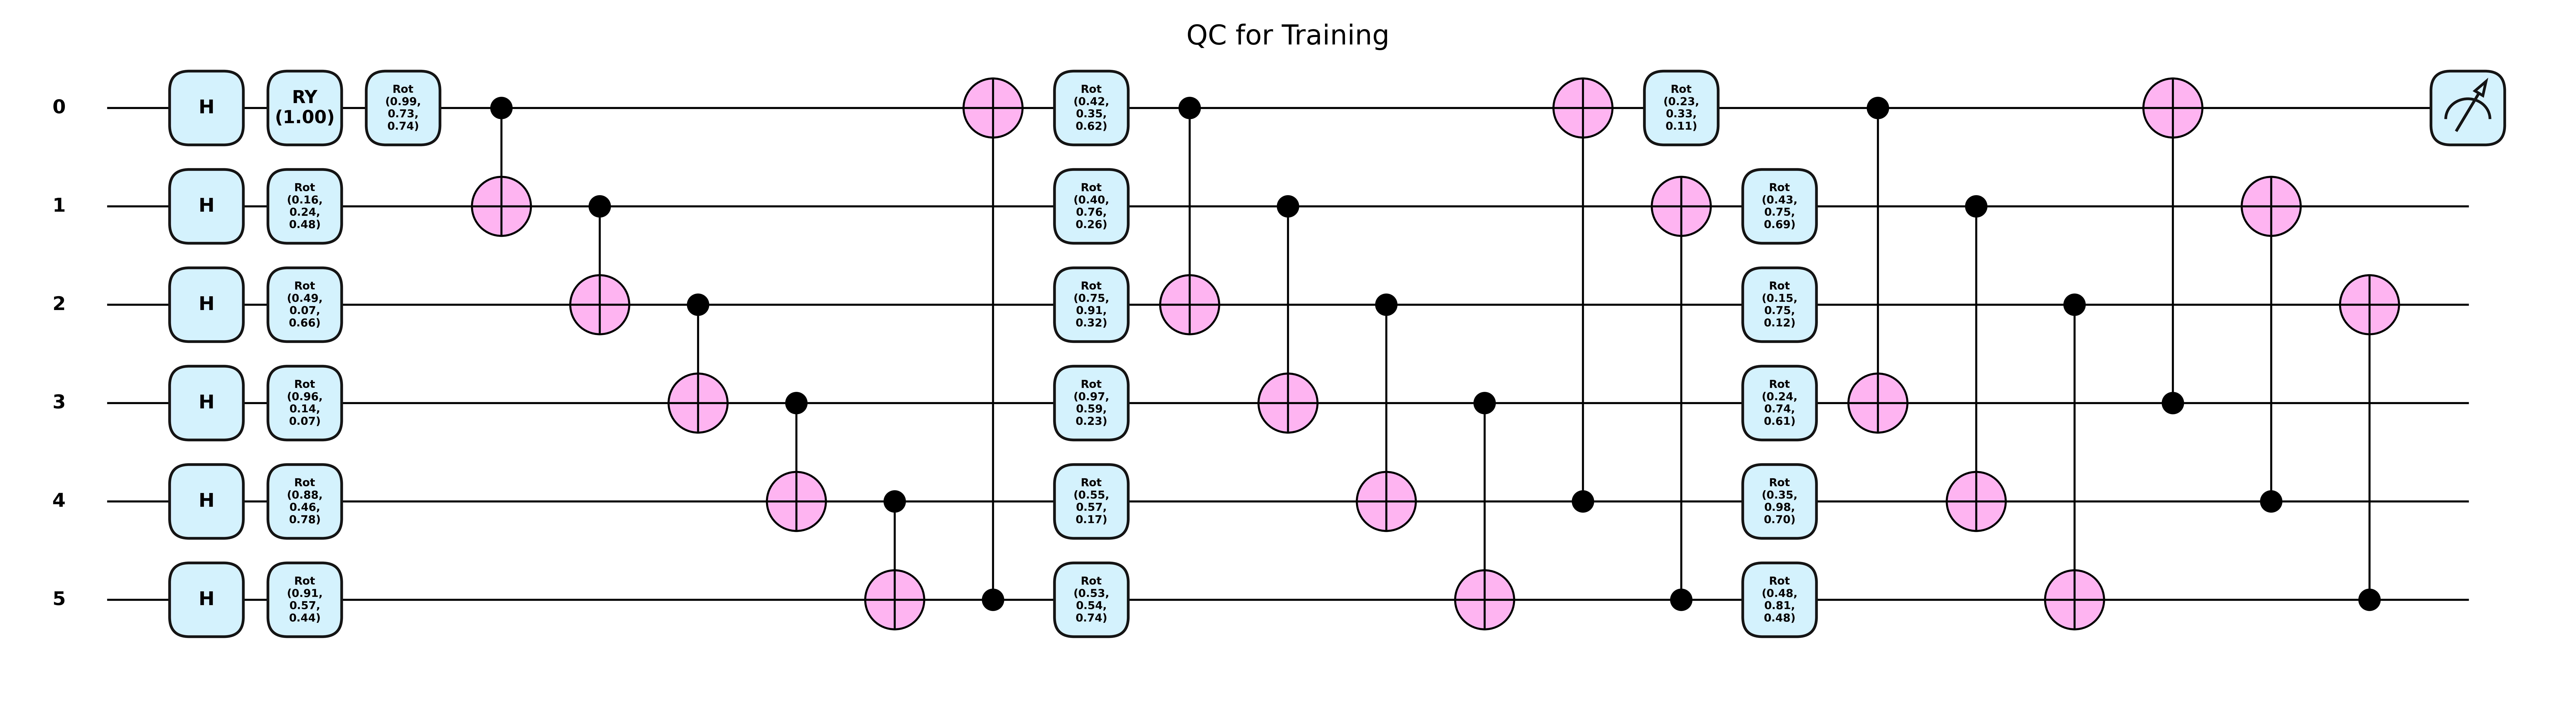

In [63]:
# Define a static QC
qc = quantum_circuit(wires, input_wires=input_wires, output_wires=output_wires, rot=rotation)

# Create and draw a QC
dev = qml.device(sim, wires=n_qubits, shots=shots)
qae_in_qc = qml.QNode(qc, dev, interface='torch', expansion_strategy='device')
draw_circuit(qae_in_qc, scale=5, title='QC for Training', expansion_strategy='device') \
    (data_in, weights_in) # expansion_strategy='device'/'gradient'

In [64]:
from model import Pure_QN

In [65]:
shots = 100 # 1000

n_qubits = 6
n_layers= 3

n_qubits_input = 1
n_qubits_output = 1

rotation = 'Rxyz'

### Define wires
wires = list(range(n_qubits))
input_wires = list(range(1))
output_wires = list(range(1))

device = qml.device('default.qubit.torch', wires = n_qubits)# default.qubit lightning.qubit lightning.gpu
torch_device = "cpu"

In [66]:
pure_qc = Pure_QN(
    DEVICE=device,
    N_QUBITS=n_qubits,
    N_INPUT_WIRES=input_wires,
    N_LAYER=n_layers,
    N_OUTPUT_WIRES=output_wires,
    ROTATION=rotation,
    )

In [67]:
m = nn.Linear(1,1).requires_grad_(False)
weights = torch.tensor([[1]], dtype=torch.float32)

m.weight.data = weights

display(m.weight)



Parameter containing:
tensor([[1.]])

In [68]:
input = torch.Tensor(1)

print(m(input))

tensor([-0.0812])


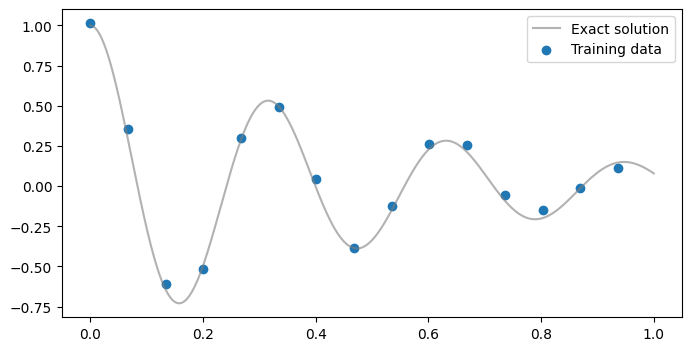

In [69]:
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'][::20].values).view(-1,1)
obs_data = torch.tensor(data['observation'][::20].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true.view(-1,1), color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

In [80]:
t_true

tensor([[0.0000],
        [0.0020],
        [0.0040],
        [0.0060],
        [0.0080],
        [0.0100],
        [0.0120],
        [0.0140],
        [0.0160],
        [0.0180],
        [0.0200],
        [0.0220],
        [0.0240],
        [0.0261],
        [0.0281],
        [0.0301],
        [0.0321],
        [0.0341],
        [0.0361],
        [0.0381],
        [0.0401],
        [0.0421],
        [0.0441],
        [0.0461],
        [0.0481],
        [0.0501],
        [0.0521],
        [0.0541],
        [0.0561],
        [0.0581],
        [0.0601],
        [0.0621],
        [0.0641],
        [0.0661],
        [0.0681],
        [0.0701],
        [0.0721],
        [0.0741],
        [0.0762],
        [0.0782],
        [0.0802],
        [0.0822],
        [0.0842],
        [0.0862],
        [0.0882],
        [0.0902],
        [0.0922],
        [0.0942],
        [0.0962],
        [0.0982],
        [0.1002],
        [0.1022],
        [0.1042],
        [0.1062],
        [0.1082],
        [0

In [83]:
t_data_aug = data['t'][::20].values

t_data_reupload = [[i]*4 for i in t_data_aug]

t_data_reupload = torch.Tensor(t_data_reupload)
display(t_data_reupload)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0669, 0.0669, 0.0669, 0.0669],
        [0.1338, 0.1338, 0.1338, 0.1338],
        [0.2007, 0.2007, 0.2007, 0.2007],
        [0.2676, 0.2676, 0.2676, 0.2676],
        [0.3344, 0.3344, 0.3344, 0.3344],
        [0.4013, 0.4013, 0.4013, 0.4013],
        [0.4682, 0.4682, 0.4682, 0.4682],
        [0.5351, 0.5351, 0.5351, 0.5351],
        [0.6020, 0.6020, 0.6020, 0.6020],
        [0.6689, 0.6689, 0.6689, 0.6689],
        [0.7358, 0.7358, 0.7358, 0.7358],
        [0.8027, 0.8027, 0.8027, 0.8027],
        [0.8696, 0.8696, 0.8696, 0.8696],
        [0.9365, 0.9365, 0.9365, 0.9365]])